In [3]:
# Imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

In [21]:
class DataSet:
    TRAINING_DIRECTORY = "train_files/"
    TEST_DIRECTORY = "example_test_files/"
    
    def __init__(self, seed = 42, train_size = 0.83):
        # Feel free to add the other .csv files here as well. 
        self._trades = pd.read_csv(self.TRAINING_DIRECTORY + "trades.csv")
        self._stock_list = pd.read_csv("stock_list.csv")
        self._stock_prices = pd.read_csv(self.TRAINING_DIRECTORY + "stock_prices.csv").fillna(0)
        
        self.seed = seed
        self.train_size = train_size
        self.has_split = False 
       
        self.X_train = dict()
        self.Y_train = dict()
        self.X_test = dict()
        self.Y_test = dict()
     
    def stocks(self) -> np.ndarray:
        return self._stock_prices["SecuritiesCode"].unique()
     
    def __split(self):
        if self.has_split:
            return 
        
        security_codes = self._stock_prices["SecuritiesCode"].unique()        
        for security_code in security_codes:
            stock_info = self._stock_prices[self._stock_prices["SecuritiesCode"] == security_code]
            features = stock_info.drop(["Target", "Date", "RowId"], axis = 1).to_numpy(dtype='float', na_value = 0)
            target = stock_info["Target"].to_numpy(dtype='float', na_value = 0)
            
            curr_x_train, curr_x_test, curr_y_train, curr_y_test = train_test_split(features, target, train_size = self.train_size, random_state = self.seed)
            self.X_train[security_code] = np.array(curr_x_train)
            self.X_test[security_code] = np.array(curr_x_test)
            self.Y_train[security_code] = np.array(curr_y_train)
            self.Y_test[security_code] = np.array(curr_y_test)
            
        self.has_split = True 
    
    def _collate_data(self, data: dict) -> np.ndarray:
        values = list(data.values())
        return np.concatenate(values, axis = 0)
        
    # Using methods below without specifying a security is a bit ugly...
    def x_train(self, security = None) -> np.ndarray:
        if not self.has_split:
            self.__split()
            
        if security is not None:
            return self.X_train[security]
        
        return self._collate_data(self.X_train)
        
    def x_test(self, security = None) -> np.ndarray:
        if not self.has_split:
            self.__split()
            
        if security is not None:
            return self.X_test[security]            
        
        return self._collate_data(self.X_test)

    def y_train(self, security = None) -> np.ndarray:
        if not self.has_split:
            self.__split()
            
        if security is not None:
            return self.Y_train[security]   
        
        return self._collate_data(self.Y_train)
            
    def y_test(self, security = None) -> np.ndarray:
        if not self.has_split:
            self.__split()
            
        if security is not  None:
            return self.Y_test[security]
        
        return self._collate_data(self.Y_test)
        
    # Use below if you wish to get the raw DataFrames 
    def stock_list(self) -> pd.DataFrame:
        return self._stock_list
    
    def trades(self) -> pd.DataFrame:
        return self._trades
    
    def stock_prices(self) -> pd.DataFrame:
        return self._stock_prices

ds = DataSet()
print(ds.x_train())

[[1.301e+03 2.948e+03 2.963e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [1.301e+03 2.579e+03 2.582e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [1.301e+03 2.900e+03 2.946e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 ...
 [4.169e+03 2.114e+03 2.200e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [4.169e+03 3.565e+03 3.775e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [4.169e+03 2.177e+03 2.300e+03 ... 1.000e+00 0.000e+00 0.000e+00]]
[[1.301e+03 2.948e+03 2.963e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [1.301e+03 2.579e+03 2.582e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [1.301e+03 2.900e+03 2.946e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 ...
 [4.169e+03 2.114e+03 2.200e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [4.169e+03 3.565e+03 3.775e+03 ... 1.000e+00 0.000e+00 0.000e+00]
 [4.169e+03 2.177e+03 2.300e+03 ... 1.000e+00 0.000e+00 0.000e+00]]


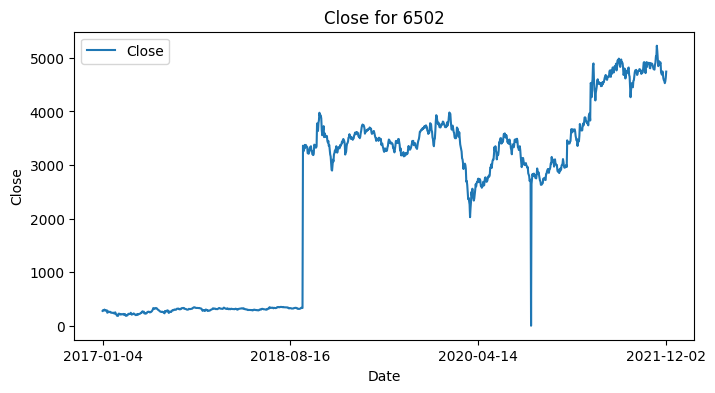

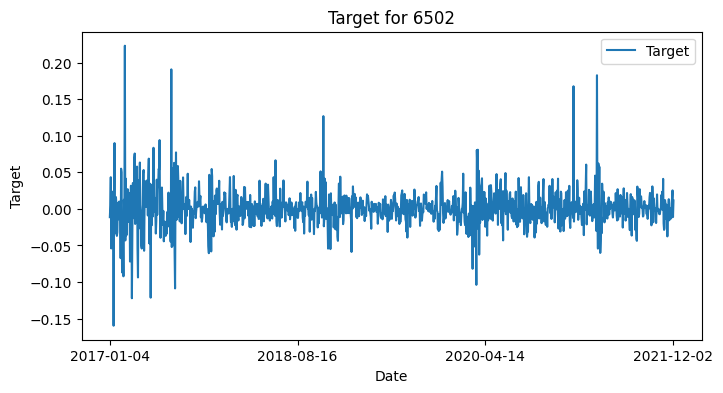

In [5]:
def plot_stock_price(securities_code):
    df = ds.stock_prices()
    df[df["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Close", figsize=(8,4))
    plt.ylabel("Close")
    plt.title("Close for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()

def plot_stock_target(securities_code):
    df = ds.stock_prices()
    df[df["SecuritiesCode"] == securities_code].plot(x = "Date", y = "Target", figsize=(8,4))
    plt.ylabel("Target")
    plt.title("Target for {}".format(securities_code))
    plt.locator_params(axis='x', nbins=8)
    plt.show()

plot_stock_price(6502)
plot_stock_target(6502)


Linear Regression Loss: 1.0858173425862618
Ridge Regression Loss: 1.0775232244466337
Elastic Net Loss: 1.076611694295603


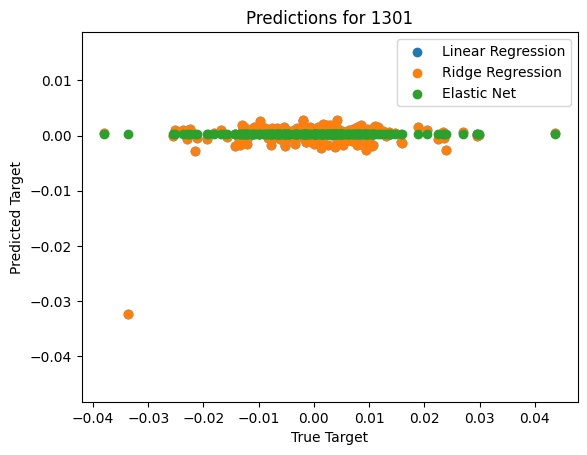

In [10]:
# Matt's Linear Models

class BasicModels:
    def __init__(self):
        self.basic_features = [
            "SecuritiesCode",
            "Close",
            "Volume",
            "ExpectedDividend",
            "Open",
            "Close",
            "High",
            "Low",
            "Volume",
            "SupervisionFlag"
        ]
        self.ds = DataSet()
        self.lr_models = dict()
        self.rg_models = dict()
        self.en_models = dict()
        self.trained = False

    def train(self):
        if self.trained:
            return 
        
        for security_code in self.ds.stocks():
            x_train = self.ds.x_train(security_code)
            y_train = self.ds.y_train(security_code)
            
            cv_alpha = make_pipeline(
                StandardScaler(), 
                RidgeCV(alphas = np.logspace(-6, 6, 13))
            ).fit(x_train, y_train).named_steps['ridgecv'].alpha_
            
            lr_model = make_pipeline(StandardScaler(), LinearRegression()).fit(x_train, y_train)
            rg_model = make_pipeline(StandardScaler(), Ridge(alpha = cv_alpha)).fit(x_train, y_train)
            en_model = make_pipeline(StandardScaler(), ElasticNet()).fit(x_train, y_train)
            
            self.lr_models[security_code] = lr_model
            self.rg_models[security_code] = rg_model
            self.en_models[security_code] = en_model
        
        self.trained = True 
        
    def _compute_model_loss(self, models):
        mse_sum = 0
        for security_code in self.ds.stocks():
            x_test = self.ds.x_test(security_code)
            y_test = self.ds.y_test(security_code)
            
            lr_model = models[security_code]
            y_pred = lr_model.predict(x_test)
            
            mse = mean_squared_error(y_test, y_pred)
            mse_sum += mse
        return mse_sum
        
    def compute_model_losses(self):
        if self.trained == False:
            self.train()
    
        lr_loss = self._compute_model_loss(self.lr_models)
        rg_loss = self._compute_model_loss(self.rg_models)
        en_loss = self._compute_model_loss(self.en_models)
            
        print(f"Linear Regression Loss: {lr_loss}")
        print(f"Ridge Regression Loss: {rg_loss}")
        print(f"Elastic Net Loss: {en_loss}")
        
    def plot_results(self):
        for security_code in self.ds.stocks():
            x_test = self.ds.x_test(security_code)
            y_test = self.ds.y_test(security_code)
            
            lr_model = self.rg_models[security_code]
            lr_y_pred = lr_model.predict(x_test)
            
            rg_model = self.rg_models[security_code]
            rg_y_pred = rg_model.predict(x_test)
            
            en_model = self.en_models[security_code]
            en_y_pred = en_model.predict(x_test)
            
            fig, ax = plt.subplots()
            ax.scatter(y_test, lr_y_pred, label = "Linear Regression")
            ax.scatter(y_test, rg_y_pred, label = "Ridge Regression")
            ax.scatter(y_test, en_y_pred, label = "Elastic Net")
            
            ax.legend() 
            
            plt.xlabel("True Target")
            plt.ylabel("Predicted Target")
            plt.title("Predictions for {}".format(security_code))
            plt.axis('equal')
            plt.show()
            return 
        
bm = BasicModels()
bm.compute_model_losses()
bm.plot_results()
